# Energy Consumtion Netherlands

Energie is duur. Dat weet iedereen. Tijdens dit project gaan "de Potter Robin" & "Verhaegen Stijn" een analyse doen over het energie verbruik in Nederland.

## Inhoud analyse

1. `Lijst inhoud analyse`

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.rdd import RDD
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.sql.functions import col
import glob
import os

In [2]:
spark = SparkSession.builder.appName("EnergyConsumption").getOrCreate()
sc = spark.sparkContext

21/10/27 17:41:53 WARN Utils: Your hostname, Stijns-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.120 instead (on interface en0)
21/10/27 17:41:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/10/27 17:41:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Path naar de data

In [3]:
path_gas = r"./data/Gas/"
path_electricity = r"./data/Electricity/"

In [4]:
def add_year(r, year):
    new_row = r + "," + year
    new_row = new_row.split(",")
    return new_row

De functie "make_rdd" gaat een spark RDD maken adhv een path naar de raw data. Tijdens het aanmaken van de RDD gaat men ook het jaar toevoegen van wanneer de data is opgenomen. Nadien worden alle headings eruit gefiltert.

In [5]:
def make_rdd(path):
    rdd_full = sc.emptyRDD()
    for filename in os.listdir(path):
        # Read file and assign data
        data = sc.textFile(path + filename)
        # Get year
        year = filename[-8:]
        year = year[0:4]
        # Create structure
        rdd = data.map(lambda r: add_year(r, year))
        # Add rdd to rdd_full
        rdd_full = rdd_full.union(rdd)
    heading = rdd_full.first()
    rdd_full = rdd_full.filter(lambda r: r != heading)
    return rdd_full

In [6]:
rdd_gas = make_rdd(path_gas)
rdd_gas.first()

['8717127750009',
 'GAS Gastransport Services (GASUNIE)',
 'Poststraat',
 '4301AA',
 '4301AA',
 'ZIERIKZEE',
 '14',
 '100.0',
 '100.0',
 '"50',
 '00"',
 'G4',
 '3736',
 '0.0',
 '0.0',
 '2015']

In [7]:
rdd_electricity = make_rdd(path_electricity)
rdd_electricity.first()

['8716874000009',
 'Stedin Utrecht',
 'Egelshoek',
 '1213RC',
 '1231AB',
 'HILVERSUM',
 '30',
 '90.0',
 '100',
 '80',
 '3x25',
 '5909',
 '90.0',
 '53.33',
 '2019']

We gaan hier de RDD van electricity omzetten naar een DataFrame.

In [8]:
heading = ["net_manager","purchase_area","street","zipcode_from","zipcode_to","city","num_connections","delivery_perc","perc_of_active_connections","type_conn_perc","type_of_connection","annual_consume","annual_consume_lowtarif_perc","smartmeter_perc", "year"]
df_electricity = rdd_electricity.toDF(heading)

df_electricity.show(2, vertical = True)

-RECORD 0--------------------------------------
 net_manager                  | 8716874000009  
 purchase_area                | Stedin Utrecht 
 street                       | Egelshoek      
 zipcode_from                 | 1213RC         
 zipcode_to                   | 1231AB         
 city                         | HILVERSUM      
 num_connections              | 30             
 delivery_perc                | 90.0           
 perc_of_active_connections   | 100            
 type_conn_perc               | 80             
 type_of_connection           | 3x25           
 annual_consume               | 5909           
 annual_consume_lowtarif_perc | 90.0           
 smartmeter_perc              | 53.33          
 year                         | 2019           
-RECORD 1--------------------------------------
 net_manager                  | 8716874000009  
 purchase_area                | Stedin Utrecht 
 street                       | Rembrandtlaan  
 zipcode_from                 | 1231AC  

En nu ook voor gas.

In [9]:
df_gas = rdd_gas.toDF(heading)

df_gas.show(2, vertical=True)

-RECORD 0--------------------------------------------
 net_manager                  | 8717127750009        
 purchase_area                | GAS Gastransport ... 
 street                       | Poststraat           
 zipcode_from                 | 4301AA               
 zipcode_to                   | 4301AA               
 city                         | ZIERIKZEE            
 num_connections              | 14                   
 delivery_perc                | 100.0                
 perc_of_active_connections   | 100.0                
 type_conn_perc               | "50                  
 type_of_connection           | 00"                  
 annual_consume               | G4                   
 annual_consume_lowtarif_perc | 3736                 
 smartmeter_perc              | 0.0                  
 year                         | 0.0                  
 _16                          | 2015                 
-RECORD 1--------------------------------------------
 net_manager                

In [10]:
x_axis = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
y_axis = []

# annual_consume_year = plt.figure(figsize=(7, 7))
# ax = annual_consume_year.add_subplot(111)
# ax.bar(x_axis, y_axis, fc='darksalmon', align='center')
# plt.show()

In [11]:
df_electricity_production = spark.read.option("header","true").option("inferSchema", "true").csv("./data/Elektriciteit__aanbod_en_verbruik_12102021_102309.csv", sep=";")
electricity_production_raw = sc.textFile("./data/Elektriciteit__aanbod_en_verbruik_12102021_102309.csv")

df_electricity_production.show(vertical = True)
df_electricity_production.printSchema()

21/10/27 17:42:11 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0---------------------------------------------------------------------------------
 Perioden                                                                        | 2013   
 Bruto productie (mln kWh)                                                       | 100875 
 Eigen verbruik bij elektr.productie (mln kWh)                                   | 3505   
 Netto productie/Netto productie, totaal (mln kWh)                               | 97370  
 Netto productie/Kernenergie (mln kWh)                                           | null   
 Netto productie/Brandstoffen/Brandstoffen, totaal (mln kWh)                     | null   
 Netto productie/Brandstoffen/Kolen (mln kWh)                                    | null   
 Netto productie/Brandstoffen/Olieproducten (mln kWh)                            | null   
 Netto productie/Brandstoffen/Aardgas (mln kWh)                                  | null   
 Netto productie/Brandstoffen/Biomassa (mln kWh)                                 | 5277   

In [12]:
# Load a text file and convert each line to a Row, so that a DataFrame can be made.

electricity_production_parts = electricity_production_raw.map(lambda l: l.split(";"))
electricity_production_rows = electricity_production_parts.map(lambda l: Row(periode=l[0], netto_productie=l[3],
                                                                             netto_productie_brandstoffen=l[5],
                                                                             netto_productie_windenergie=l[12],
                                                                             netto_productie_zonnestroom=l[15]))

In [13]:
electricity_production_rows.take(2)


[Row(periode='"Perioden"', netto_productie='"Netto productie/Netto productie, totaal (mln kWh)"', netto_productie_brandstoffen='"Netto productie/Brandstoffen/Brandstoffen, totaal (mln kWh)"', netto_productie_windenergie='"Netto productie/Windenergie/Windenergie, totaal (mln kWh)"', netto_productie_zonnestroom='"Netto productie/Zonnestroom (mln kWh)"'),
 Row(periode='"2013"', netto_productie='97370', netto_productie_brandstoffen='', netto_productie_windenergie='5627', netto_productie_zonnestroom='410')]

In [14]:

header = electricity_production_rows.first()
df_electricity_production = spark.createDataFrame(electricity_production_rows.filter(lambda row: row != header))

In [15]:
df_electricity_production.show()

df2_electricity_production = df_electricity_production.selectExpr("cast(periode as string) periode",
                                                                  "cast(netto_productie as int) netto_productie",
                                                                  "cast(netto_productie_brandstoffen as int) netto_productie_brandstoffen",
                                                                  "cast(netto_productie_windenergie as int) netto_productie_windenergie",
                                                                  "cast(netto_productie_zonnestroom as int) netto_productie_zonnestroom")
df2_electricity_production.printSchema()

+--------+---------------+----------------------------+---------------------------+---------------------------+
| periode|netto_productie|netto_productie_brandstoffen|netto_productie_windenergie|netto_productie_zonnestroom|
+--------+---------------+----------------------------+---------------------------+---------------------------+
|  "2013"|          97370|                            |                       5627|                        410|
|  "2014"|          99310|                            |                       5797|                        725|
|  "2015"|         105902|                       91907|                       7550|                       1109|
|  "2016"|         111032|                       96122|                       8170|                       1602|
|  "2017"|         113465|                       95895|                      10569|                       2204|
|  "2018"|         110692|                       92429|                      10549|                     

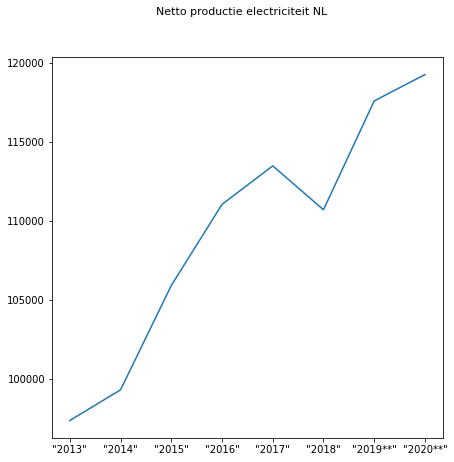

In [16]:
# Get values from the needed columns in a List to use them to plot.
x_axis = df2_electricity_production.rdd.map(lambda l:l.periode).collect()
y_axis = df2_electricity_production.rdd.map(lambda l:l.netto_productie).collect()
figure_netto_production = plt.figure(figsize=(7, 7))
figure_netto_production.suptitle('Netto productie electriciteit NL', fontsize=11)
plt1 = figure_netto_production.add_subplot(111)
plt1.plot(x_axis, y_axis)
plt.show()
#TODO: change year values to only contain the year like 2013 and not "2013"

[Row(periode='"2020**"', netto_productie=119238, netto_productie_brandstoffen=91383, netto_productie_windenergie=15339, netto_productie_zonnestroom=8144)]
[91383, 15339, 8144]


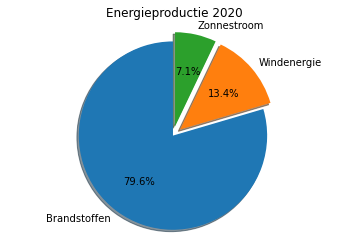

In [17]:
# Lets focus on renewable, show how much the share of renewable energy is of the whole netto production
# Show it in a pie charm for the year 2020
labels = "Brandstoffen","Windenergie","Zonnestroom"
energy_distribution_2020 = df2_electricity_production.filter(df2_electricity_production.periode == '\"2020**\"').collect()
print(energy_distribution_2020)
data_2020 = [energy_distribution_2020[0].asDict()["netto_productie_brandstoffen"],energy_distribution_2020[0].asDict()["netto_productie_windenergie"],energy_distribution_2020[0].asDict()["netto_productie_zonnestroom"]]
print(data_2020)
explode = (0, 0.1, 0.1)  # only "explode" the 2nd slice 
fig1, ax1 = plt.subplots()
plt.title('Energieproductie 2020')
ax1.pie(data_2020, explode=explode, labels=labels, autopct='%1.1f%%',
shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
## TODO: make a slider so you can choose for which year you want to see the pie chart and show the pie chart for the selected year"
